Project: Wine Reviews
Data source: The main dataset is the semi-structured data from Wine Enthusiast Magazine Wine Ratings from Kaggle: 
https://www.kaggle.com/datasets/zynicide/wine-reviews
Creator: Meichan Huang
Date: 11/7/22

In this project, I worked with the following data sources:
(1) the original dataset from 2017 approximately 130k wine review data. 
(2) a dataset containing new reviews from 2017 - 2020 from Kaggle: https://www.kaggle.com/datasets/manyregression/updated-wine-enthusiast-review. 
The second author has already been cleaned and removed all the duplicates from the original 2017 dataset, but there are some columns that are not in the original data.
(3) Geolocation (Longitude and Latitude data for the World and States: https://www.kaggle.com/datasets/paultimothymooney/latitude-and-longitude-for-every-country-and-state
(4) Twitter data I have scrapped during HW2 using hashtags #wine and #winereviews

I seek to answer the following questions: 

Data Questions: 
Question 1: Which countries and provinces had the MOST and LEAST reviews (demographic distributions of wine reviews)?
Question 2: What is the MEAN, MIN and MAX points received for wines from the most and least reviewed countries and provinces? 
Question 3: What was the MEAN, MIN and MAX price of wine by country?
Question 4: How many wines were reviewed by category? What are the top 10 wine varieties reviewed?
Question 5: What are the MEAN, MIN and MAX scores, particular for top 10 most reviewed varieties?
Question 6: What was the MEAN, MIN and MAX prices of wine by top 10 reviewed varieties?
Question 7: For each country, what type of wine is most reviewed?
Question 8: What is the correlation between the price and score of a bottle of wine?
Question 9: What types of descriptors were frequently associated categories of wine in the reviews? e.g. what kind of fruit flavor were typically used in the wine reviews? 
Question 10: Who were the top 10 accounts posted during the time period of 11/14/2022 to 11/24/2022 and what types? 
Question 11: How many users tweeted during the week prior to Thanksgiving based on the Date? 
Question 12: How many users tweeted for each hour of the day during the time period? In other words, at what time did users tweet more frequently compared to other hours? 

I took the following steps to complete the data analysis
Packages: NumPy, Pandas, Matplotlab, seaborn, geopandas, pycountry, json, mapclassify, nltk, and sklearn. 

Data preprocessing: 
(1)	Load the two csv from Kaggle and perform concat & import twitter data from MongoDB 
(2)	Save the data into csv based on the labels, e.g. countries, regions, price, points. 
(3)	Clean the data: treat missing data (remove NAs; impute the missing values with the mode) and adjust for anomality.
(4) Tokenize the review data using NLTK for word-clouds (for Q7 mainly) 
Data analysis: 
(5)	Filter the dataset with Groupby and Pivot to include the variables that are of interest for each question. 
(6)	Conduct descriptive analysis of the data.
(7)	Run the linear regression model to determine the relationship between price and scores.
(8)	Use NLTK to count word frequencies associated with each category of wine.

https://docs.google.com/document/d/1fcIfQT73Wmy4U3jkgN9eQI6snHsBOJ7lu-Vq9DrAIEo/edit 

In [944]:
'''Import necessary packages for import the dataframe'''
import nltk
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas
import pycountry 
import mapclassify
from sklearn.linear_model import LinearRegression
import json

In [906]:
'''Step 1: Import the two dataset to the pandas dataframe and preprocess for analysis'''

#Read the first Kaggle dataset from the csv file with necessary columns for the analysis: 
winereview1 = pd.read_csv('winemag-data-130k-v2.csv',sep=",")

winereview1.drop(winereview1.columns[[0]], axis=1, inplace=True)   #since the second data does not have a column specifically for the index, I will drop this column for analysis
winereview1 = winereview1.loc[:, ["country", "description", "points", "price", "province", 
               "variety"]]

In [907]:
#View the first four five rows 
winereview1.head()

#Looks like price column have already missing values. 

,country,description,points,price,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir


In [908]:
#Read the second Kaggle dataset from the csv file with necessary columns for the analysis: 
winereview2 = pd.read_csv('winemag-data-2017-2020.csv', sep=',')

winereview2 = winereview2.loc[:, ["country", "description", "points", "price", "province", 
               "variety"]]
print(len(winereview1))

129971


In [909]:
#Append two dataframe together to be a new dataframe 
winereviews = winereview1.append(winereview2, ignore_index=True)

/var/folders/94/jd4kq_w52nlgjf9bgbdl12lw0000gn/T/ipykernel_48033/1428619938.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [910]:
#Inspect the shape of the data, how many rows and columns specifically. 
shape = winereviews.shape
print("The shape of the dataframe (rows, columns):\t {}".format(shape))

#Inspect the data types for the dataframe
print(winereviews.dtypes)

#There were 211086 rows of reviews (129971 entries for 1st dataset + 81115 entries for 2nd dataset), with 10 attributes. Also, the data type looks like they do not need any adjustment. 

The shape of the dataframe (rows, columns):	 (211086, 6)
country         object
description     object
points           int64
price          float64
province        object
variety         object
dtype: object


In [911]:
#Inspect empty values and impute the data if needed.
print(winereviews.isnull().any())   #Is there any NAs in each column and the output is a boolean value. 
print(winereviews.isnull().sum())  #the total number of null values in each column

'''The most important variables that will need to be used are: country, price, points, review, and variety. 
#Therefore, the treatment of NAs in the dataset will focus on the following columns and treatment specified: 
(1) Country: remove the ones without a country (68 records)
(2) Price: impute the price (13643 records) since there are too many datapoints missing.
(3) Province: remove the ones without a province (68 records) 
(4) Variety: 1 value missing
'''

country         True
description    False
points         False
price           True
province        True
variety         True
dtype: bool
country           68
description        0
points             0
price          13643
province          68
variety            1
dtype: int64


'The most important variables that will need to be used are: country, price, points, review, and variety. \n#Therefore, the treatment of NAs in the dataset will focus on the following columns and treatment specified: \n(1) Country: remove the ones without a country (68 records)\n(2) Price: impute the price (13643 records) since there are too many datapoints missing.\n(3) Province: remove the ones without a province (68 records) \n(4) Variety: 1 value missing\n'

In [912]:
#Remove the records with NAs in the country and province column:
winereviews = winereviews.dropna(how="any", subset=["country", "province", "variety"])

/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



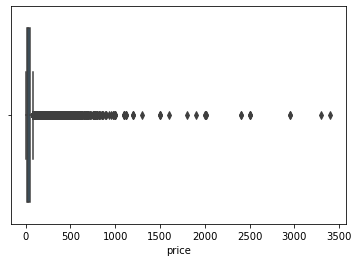

In [913]:
#Impute the price: https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
#Visualize the price column and see the distribution of the data
sns.boxplot(winereviews.price)
#It looks like the data is rather skewed, therefore, taking the mode (the most frequent price) would be a good strategy. 

winereviews['price'] = winereviews['price'].fillna(winereviews['price'].mode()[0])

In [914]:
#Meichan: Check the updated dataframe with the columns with necessary NA processing 
winereviews.describe()

,points,price
count,211017.000000,211017.000000
mean,88.806850,35.757456
std,3.028514,42.733794
min,80.000000,4.000000
25%,87.000000,18.000000
50%,89.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3400.000000


In [915]:
#the total number of null values in each column after cleaning
print(winereviews.isnull().sum())  

country        0
description    0
points         0
price          0
province       0
variety        0
dtype: int64


In [916]:
#Create a new column with words tokenized, punctuation, stopwords removed for the word cloud.

#To make the process faster, I found this solution: https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
winereviews['tokenized_words'] = winereviews['description'].apply(lambda x: nltk.word_tokenize(x))


In [917]:
#lower case all items in the list for each column
winereviews['tokenized_words'] = winereviews['tokenized_words'].map(lambda x: list(map(str.lower, x)))

In [918]:
#Remove the punctuation and numbers 
import re
def alpha_filter(w):
     pattern = re.compile('^[^a-z]+$')
     if (pattern.match(w)):
         return True
     else:
         return False   
winereviews['tokenized_words'] = winereviews['tokenized_words'].apply(lambda x:[i for i in x if not alpha_filter(i)])

In [919]:
#Remove stopwords and punctuation 
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")
mystopwords = ['drink' , 'now', 'wine' ,'flavour','flavor', "'s",'still', 'flavours', 'flavors', "'ll"]   #customized list of stopwords. 
stopwords.extend(mystopwords)

#Save a new column to store the preprocessed word tokens 
winereviews['tokenized_words'] = winereviews['tokenized_words'].apply(lambda x:[i for i in x if i not in stopwords])

In [920]:
winereviews.head()

,country,description,points,price,province,variety,tokenized_words
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,20.0,Sicily & Sardinia,White Blend,"[aromas, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,"[ripe, fruity, smooth, structured, firm, tanni..."
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,"[tart, snappy, lime, flesh, rind, dominate, gr..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,"[pineapple, rind, lemon, pith, orange, blossom..."
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,"[much, like, regular, bottling, comes, across,..."


In [921]:
##Write the data out to csv file for furture use for ease of retrival
winereviews.to_csv('winereviewupdated.csv')

In [922]:
'''Step 2: Retrieve the columns that are useful for the data analysis: Index, Country, Points, Price, Province, Region_1(for ) Variety, tokenized_words'''

reviewdf = pd.read_csv('winereviewupdated.csv',sep=",")


In [923]:
#Inspect if the reviewdf1 is loaded with the right columns. 
reviewdf1.head()

,country,description,points,price,province,variety,tokenized_words
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,20.0,Sicily & Sardinia,White Blend,"['aromas', 'include', 'tropical', 'fruit', 'br..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,"['ripe', 'fruity', 'smooth', 'structured', 'fi..."
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,"['tart', 'snappy', 'lime', 'flesh', 'rind', 'd..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,"['pineapple', 'rind', 'lemon', 'pith', 'orange..."
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,"['much', 'like', 'regular', 'bottling', 'comes..."


In [924]:
reviewdf1.describe()

,points,price
count,211017.000000,211017.000000
mean,88.806850,35.757456
std,3.028514,42.733794
min,80.000000,4.000000
25%,87.000000,18.000000
50%,89.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3400.000000


In [925]:
# Standard Deviation of the DataFrame
reviewdf1.std()

/var/folders/94/jd4kq_w52nlgjf9bgbdl12lw0000gn/T/ipykernel_48033/631400350.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



points     3.028514
price     42.733794
dtype: float64

In [926]:
'''Step 3: Data analysis'''

#Question (1) Which countries and provinces had the MOST and LEAST reviews (demographic distributions of wine reviews)?

#Start with the descriptive stats of the variable Country: 

reviewdf1["country"].describe()

count     211017
unique        45
top           US
freq       86678
Name: country, dtype: object

The top three countries that have most wine reviews are:
 country
US        86678
France    40494
Italy     30219
Name: description, dtype: int64
The top three countries that have least wine reviews are:
 country
Bosnia and Herzegovina    10
China                      8
Global                     2
Slovakia                   1
Egypt                      1
Name: description, dtype: int64


'Findings: The data showed that wines from three countries have received most reviews, namely US, France, and Italy.\nOn the other hand, China, Slovakia, and Egypt are the countries which had the least reviews per country. Global is not countries and was not included in the discussion. \n'

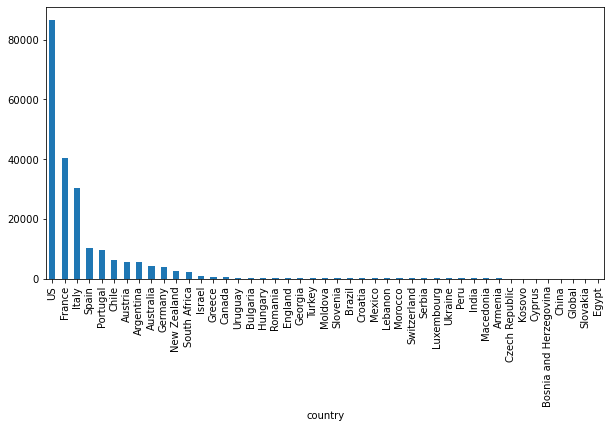

In [927]:
#To understand how many reviews that wines from other countries receive, other than U.S. I will use a groupby function and count the length of description based on countries.  
reviewbycountry = reviewdf1['description'].groupby([reviewdf1['country']]).size().sort_values(ascending=False)

print("The top three countries that have most wine reviews are:\n", reviewbycountry.head(3))
print("The top three countries that have least wine reviews are:\n", reviewbycountry.tail(5))

#Plot the bar chart and see the distribution of the counts of reviews by countries. 
plot1 = reviewbycountry.plot.bar(y='description', figsize=(10, 5))

reviewbycountry.to_csv('reviewbycountry.csv')

'''Findings: The data showed that wines from three countries have received most reviews, namely US, France, and Italy.
On the other hand, China, Slovakia, and Egypt are the countries which had the least reviews per country. Global is not countries and was not included in the discussion. 
'''

In [928]:
##Lastly, creating a geomap using geopandas to map out the country. First load the data into Jupyter notebook.  
geodf=pd.read_csv('reviewbycountry.csv', sep=",")
geodf['country'] = geodf['country'].replace('US','United States') #This step is to help joining the data because I had some issue joining the dataframes with United States because it was US in the original data.

In [929]:
# generate country code based on country name. To help with the task, I have used the following sources:
# (1)https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b
# (2)https://stackoverflow.com/questions/63877348/how-do-i-set-dot-sizes-and-colors-for-a-plotly-express-scatter-geo
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('none')  #since in this dataset, US is already abbreviated and is not able to be transformed to abbrevated code.
    return CODE
# create a column for code 
geodf['CODE']=alpha3code(geodf.country)
geodf.to_csv('geodf.csv')

In [930]:
#Read into the geodf after manually cleaned up USA which was not successfully transferred. 
geodf = pd.read_csv('geodf.csv', sep=",")

In [931]:
# Merge geopandas data with the review by country and province data subsets: 
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
print(world)
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
world.columns
# then merge with our data 
merge=pd.merge(world,geodf,on='CODE')
merge.to_csv('geodfmerged.csv')

         pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                       

In [932]:
merge.head()

,pop_est,continent,name,CODE,gdp_md_est,geometry,Unnamed: 0,country,description
0,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",14,Canada,399
1,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0,United States,86678
2,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",7,Argentina,5587
3,18952038.0,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",5,Chile,6068
4,58558270.0,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",11,South Africa,2035


In [946]:
# merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')
mergelonglat=merge.merge(location,on='country')
mergelonglat.to_csv('mergedwithlonglat.csv')

In [947]:
mergelonglat.head()

,pop_est,continent,name,CODE,gdp_md_est,geometry,Unnamed: 0,country,description,country_code,latitude,longitude
0,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",14,Canada,399,CA,56.130366,-106.346771
1,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0,United States,86678,US,37.090240,-95.712891
2,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",7,Argentina,5587,AR,-38.416097,-63.616672
3,18952038.0,South America,Chile,CHL,282318,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335...",5,Chile,6068,CL,-35.675147,-71.542969
4,58558270.0,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",11,South Africa,2035,ZA,-30.559482,22.937506


In [950]:
#Plot the country origin of wine in the dataset. 
import plotly.express as px
description = mergelonglat['description']
px.scatter_geo(mergelonglat, lat=mergelonglat['latitude'], lon=mergelonglat['longitude'], size = 'description', color = 'country', height=600)

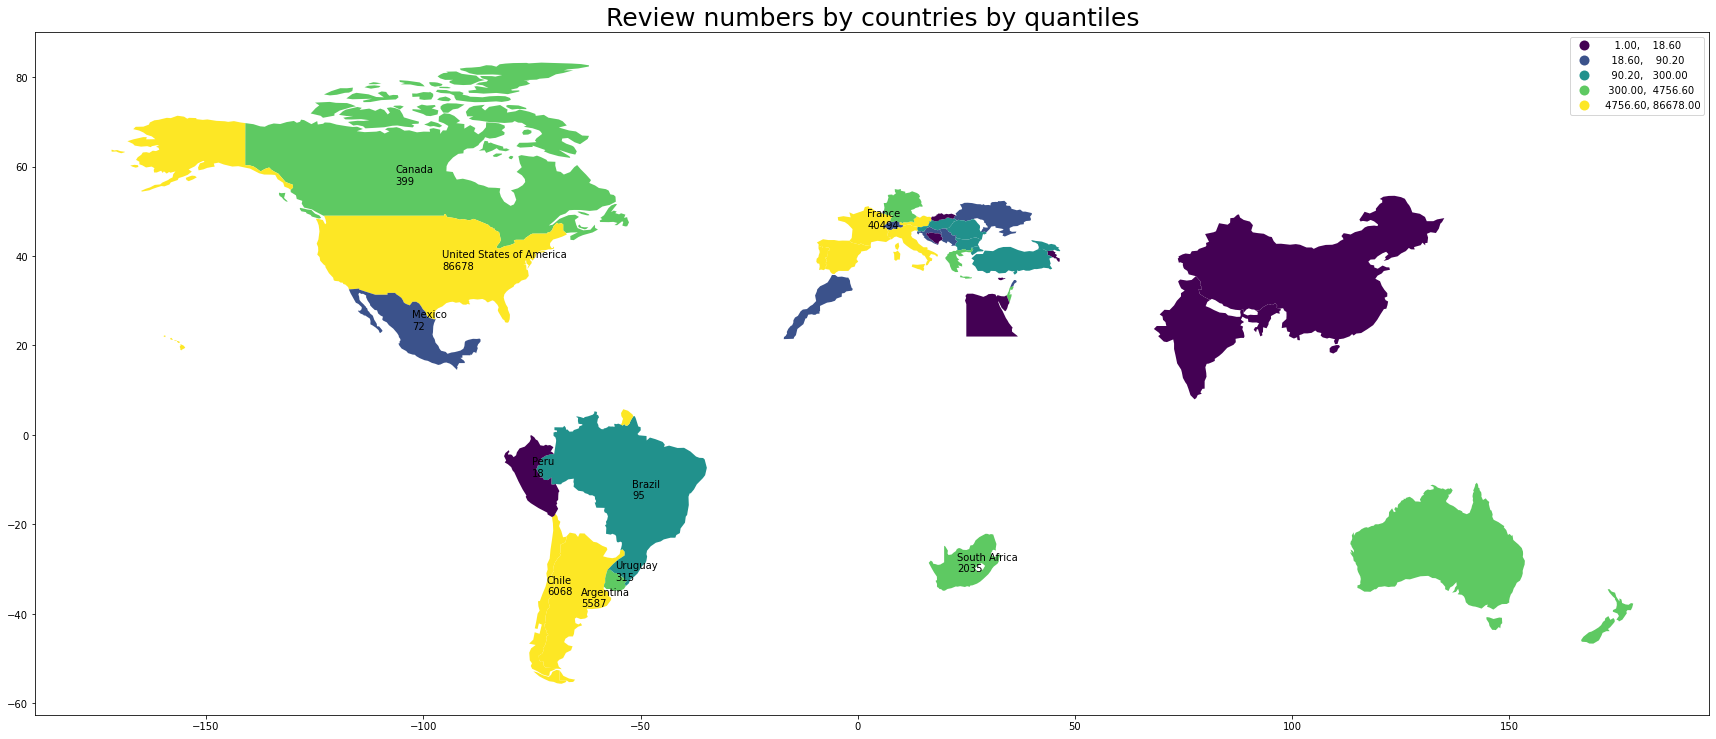

In [949]:
# plot based on the number of wine reviews by countries, the lighter the color, the more the reviews.
mergelonglat.plot(column='description',scheme = 'quantiles',
           figsize=(30, 25),
           legend=True)
plt.title('Review numbers by countries by quantiles',fontsize=25)
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(mergelonglat.longitude[i]),float(mergelonglat.latitude[i]),"{}\n{}".format(mergelonglat.name[i],mergelonglat.description[i]),size=10)
plt.show()

#The colors will be given to those countries based on their total numbers of reviews by their quantiles.

In [534]:
#Question 1.2: Which provinces in which countries have produced wines that are most frequently reviewed? 

#Again, we start with a basic descriptive analysis of the column. 
reviewdf1["province"].describe()
#As anticipated, California is the province that received the most wine reviews. 

count         211017
unique           494
top       California
freq           57760
Name: province, dtype: object

In [784]:
#Table 2: Which three provinces (states) that received most reviews and the least reviews? 
reviewbyprovince = reviewdf1['description'].groupby([reviewdf1['province']]).size().sort_values(ascending=False)
#Write out the data to csv file for later retrival:
reviewbyprovince.to_csv('reviewbyprovince.csv')

print("The wines from {} states and provinces are reviewed in this dataset".format(len(reviewbyprovince)))
print("The top three provinces/states that have most wine reviews are: \n", reviewbyprovince.head(3))
print("The three provinces/states that have least wine reviews are: \n", reviewbyprovince.tail(3))


The wines from 494 states and provinces are reviewed in this dataset
The top three provinces/states that have most wine reviews are: 
 province
California    57760
Washington    12789
Bordeaux      11057
Name: description, dtype: int64
The three provinces/states that have least wine reviews are: 
 province
Elazığ-Diyarbakir        1
Table wine               1
Muscat of Kefallonian    1
Name: description, dtype: int64


In [536]:
#Question 1.3: Which provinces in which countries have produced wines that are most frequently reviewed? 

#This question will require three columns, reviews, country and province. I wil calculate the lengths of reviews based on countries then provinces. 

reviewbycoutryprov = reviewdf1['description'].groupby([reviewdf1['country'],reviewdf1['province']]).size()

#Write out the data to csv file for later retrival:
reviewbycoutryprov.to_csv('reviewbycountry&province.csv')

AxesSubplot(0.125,0.125;0.775x0.755)


count    211017.000000
mean         88.806850
std           3.028514
min          80.000000
25%          87.000000
50%          89.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

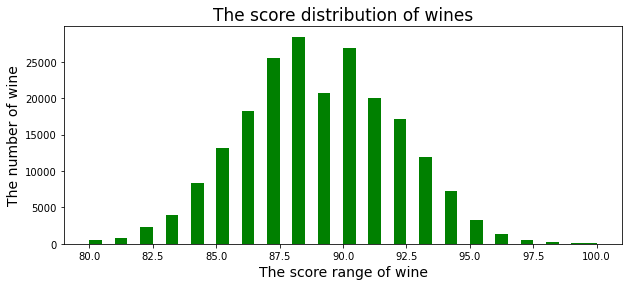

In [701]:
'''Question 2: What is the min and max point of reviews received by wines from each country and each province? '''
#Understand the point distribution of the data, as this is one of the important parameter for the regression analysis.  
#The assumption is that So, it is obviously preassumed that the higher the price, the more positive the review and higher scores. 
point_hist = reviewdf1['points'].hist(grid = False, bins = 40,color = 'green')
print(point_hist)
plt.title("The score distribution of wines", fontsize= 17)
plt.xlabel("The score range of wine", fontsize = 14)
plt.ylabel("The number of wine", fontsize = 14)

#Also, obtain the descriptive analysis of the points: 
reviewdf1['points'].describe()

In [849]:
# Group points per country - min and max points and sort the data based on the max values. 
pointbycountry = reviewdf1['points'].groupby(reviewdf1['country']).agg([len, np.mean, min, max]).sort_values('len', ascending = False)
#Save the results to csv
pointbycountry.to_csv('scorebycountry.csv')

print('The mean, max and min scores that the top five reviewed countries are', pointbycountry.head(5))
print('The mean, max and min scores that the five least reviewed countries are', pointbycountry.tail(5))

The mean, max and min scores that the top five reviewed countries are             len       mean  min  max
country                             
US        86678  88.942327   80  100
France    40494  89.244728   80  100
Italy     30219  88.827956   80  100
Spain     10120  87.343182   80   98
Portugal   9645  88.472576   80  100
The mean, max and min scores that the five least reviewed countries are                         len  mean  min  max
country                                    
Bosnia and Herzegovina   10  86.6   85   88
China                     8  89.5   85   94
Global                    2  84.0   84   84
Slovakia                  1  87.0   87   87
Egypt                     1  84.0   84   84


In [873]:
#Countries who had the perfect scored wines:  
perfectwine = reviewdf1.loc[reviewdf1['points']== 100]
print('There were {} perfect wine.'.format(len(perfectwine)))
perfect_country=pd.unique(perfectwine['country'])
perfect_country
perfectwine

There were 53 perfect wine.


,country,description,points,price,province,variety,tokenized_words
345,Australia,This wine contains some material over 100 year...,100,350.0,Victoria,Muscat,"['contains', 'material', 'years', 'old', 'show..."
7332,Italy,Thick as molasses and dark as caramelized brow...,100,210.0,Tuscany,Prugnolo Gentile,"['thick', 'molasses', 'dark', 'caramelized', '..."
36512,France,This is a fabulous wine from the greatest Cham...,100,259.0,Champagne,Champagne Blend,"['fabulous', 'greatest', 'champagne', 'vintage..."
39268,Italy,"A perfect wine from a classic vintage, the 200...",100,460.0,Tuscany,Merlot,"['perfect', 'classic', 'vintage', 'masseto', '..."
42179,Portugal,This is the latest release of what has long be...,100,450.0,Douro,Portuguese Red,"['latest', 'release', 'long', 'regarded', 'por..."
45758,Italy,"This gorgeous, fragrant wine opens with classi...",100,550.0,Tuscany,Sangiovese,"['gorgeous', 'fragrant', 'opens', 'classic', '..."
45775,US,Tasted in a flight of great and famous Napa wi...,100,200.0,California,Cabernet Sauvignon,"['tasted', 'flight', 'great', 'famous', 'napa'..."
58322,France,"This is a magnificently solid wine, initially ...",100,150.0,Bordeaux,Bordeaux-style Red Blend,"['magnificently', 'solid', 'initially', 'even'..."
89685,France,This latest incarnation of the famous brand is...,100,250.0,Champagne,Champagne Blend,"['latest', 'incarnation', 'famous', 'brand', '..."
89686,France,This new release from a great vintage for Char...,100,617.0,Champagne,Chardonnay,"['new', 'release', 'great', 'vintage', 'chardo..."


In [852]:
# Group points per province - min and max points and sort the data based on the max values. 
pointbyprovince = reviewdf1['points'].groupby(reviewdf1['province']).agg([len, np.mean, min,max]).sort_values('len', ascending=False)

#Save the results to csv
pointbyprovince.to_csv('scorebyprovince.csv')

print('The max and min scores that top 5 most reviewed state/provinces received are:\n', pointbyprovince.head(5))
print('The max and min scores that least reviewed 5 state/provinces received are: \n', pointbyprovince.tail(5))

The max and min scores that top 5 most reviewed state/provinces received are:
               len       mean  min  max
province                              
California  57760  89.114647   80  100
Washington  12789  88.817030   80  100
Bordeaux    11057  89.172289   80  100
Oregon       9880  89.411032   80  100
Tuscany      9295  89.176762   80  100
The max and min scores that least reviewed 5 state/provinces received are: 
                        len  mean  min  max
province                                  
Terras Madeirenses       1  87.0   87   87
Elandskloof              1  91.0   91   91
Elazığ-Diyarbakir        1  86.0   86   86
Table wine               1  81.0   81   81
Muscat of Kefallonian    1  87.0   87   87


In [635]:
'''Question 3: What was the average price, min, and max price of wine by country?''' 
#I start with some basic stats of price: 
reviewdf1['price'].describe()

count    211017.000000
mean         35.757456
std          42.733794
min           4.000000
25%          18.000000
50%          25.000000
75%          42.000000
max        3400.000000
Name: price, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


Text(0, 0.5, 'The number of wine')

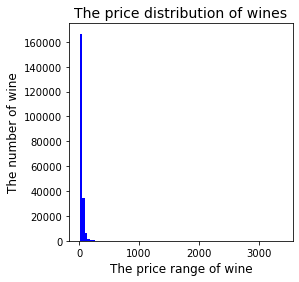

In [781]:
#Another important numeric parameter is "Points" and we will do some descriptive anlaysis
price_hist = reviewdf1['price'].hist(grid = False, bins = 80,color = 'blue')
print(point_hist)
plt.title("The price distribution of wines", fontsize= 14)
plt.xlabel("The price range of wine", fontsize = 12)
plt.ylabel("The number of wine", fontsize = 12)
#The histogram of price distribution also shows that the price distribution is highly skewed, with most of the data in a smaller range (way below 1000 dollars).  

Text(0, 0.5, 'The number of wine')

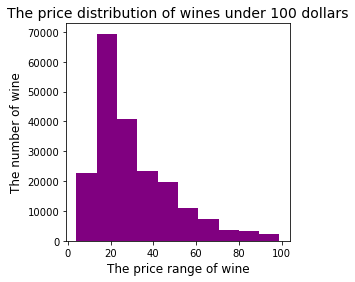

In [782]:
#When zooming in: 
price_100 = reviewdf1[reviewdf1['price'] < 100]['price']
price_100.hist(grid = False, color = 'purple')
plt.title("The price distribution of wines under 100 dollars", fontsize= 14)
plt.xlabel("The price range of wine", fontsize = 12)
plt.ylabel("The number of wine", fontsize = 12)

In [829]:
#Create a pivot table using country and price, with agg function of mean, max, and min. 
pricebycountry = reviewdf1.pivot_table(index='country', values=['price'],
                aggfunc=['mean', 'max', 'min'], fill_value=0)
print(pricebycountry)

                              mean   max   min
                             price price price
country                                       
Argentina                25.504743   350     4
Armenia                  18.941176    45    10
Australia                37.438496   897     5
Austria                  29.565380  1100     7
Bosnia and Herzegovina   21.000000    40    12
Brazil                   22.800000    60     8
Bulgaria                 15.183333   100     8
Canada                   37.649123   125    12
Chile                    21.571852   400     5
China                   128.625000   300    18
Croatia                  26.797753    70    12
Cyprus                   16.666667    21    11
Czech Republic           23.600000    45    15
Egypt                    20.000000    20    20
England                  52.737143   170    20
France                   36.904332  3400     5
Georgia                  20.275641    45     9
Germany                  39.400915   775     5
Global       

In [843]:
mostexpensive = reviewdf1.loc[reviewdf1['price'] == 3400]
print(mostexpensive)
leastexpensive = reviewdf1.loc[reviewdf1['price'] == 4]
print(len(leastexpensive))

       country                                        description  points  \
181694  France  This is like drinking liquid black currants an...     100   

         price  province                   variety  \
181694  3400.0  Bordeaux  Bordeaux-style Red Blend   

                                          tokenized_words  
181694  ['like', 'drinking', 'liquid', 'black', 'curra...  
13


In [883]:
wonderfulwine = reviewdf1.loc[(reviewdf1['price'] <=20) & (reviewdf1['points'] >=98)]
print("There are {} wine above 98 points and below 20 dollars, and these are the good wines!".format(len(wonderfulwine)))
wonderfulwine

There are 49 wine above 98 points and below 20 dollars, and these are the good wines!


,country,description,points,price,province,variety,tokenized_words
48871,France,"A beautiful, pure wine that combines freshnes...",98,20.0,Burgundy,Pinot Noir,"['beautiful', 'pure', 'combines', 'freshness',..."
109353,Austria,Opulent honey and lemon aromas waft from the g...,98,20.0,Burgenland,Welschriesling,"['opulent', 'honey', 'lemon', 'aromas', 'waft'..."
111704,France,"A big, bold wine with unbelievable power and c...",99,20.0,Bordeaux,Bordeaux-style Red Blend,"['big', 'bold', 'unbelievable', 'power', 'conc..."
111705,France,"Stern, almost severe initially, this great win...",99,20.0,Bordeaux,Bordeaux-style Red Blend,"['stern', 'almost', 'severe', 'initially', 'gr..."
111706,France,A great wine that is just starting out. The hi...,98,20.0,Bordeaux,Bordeaux-style Red Blend,"['great', 'starting', 'high', 'proportion', 'c..."
111707,France,"Dense, yes, but this is also a handsome wine t...",98,20.0,Bordeaux,Bordeaux-style Red Blend,"['dense', 'yes', 'also', 'handsome', 'balances..."
111708,France,"A firm and serious wine, complex and complicat...",98,20.0,Bordeaux,Bordeaux-style Red Blend,"['firm', 'serious', 'complex', 'complicated', ..."
111709,France,"A dense, smooth and opulent wine bursting with...",98,20.0,Bordeaux,Bordeaux-style Red Blend,"['dense', 'smooth', 'opulent', 'bursting', 'ri..."
116039,France,98-100 Barrel sample. The aromas are so rich a...,99,20.0,Bordeaux,Bordeaux-style White Blend,"['barrel', 'sample', 'aromas', 'rich', 'powerf..."
116040,France,"98-100 Barrel sample. Sumptuous, opulent, with...",99,20.0,Bordeaux,Bordeaux-style Red Blend,"['barrel', 'sample', 'sumptuous', 'opulent', '..."


In [881]:
wonderfulwine.groupby(['variety']).size()

variety
Bordeaux-style Red Blend      38
Bordeaux-style White Blend     3
Chardonnay                     1
Grenache                       2
Pinot Noir                     1
Rosenmuskateller               1
Sangiovese                     1
Welschriesling                 1
Zweigelt                       1
dtype: int64

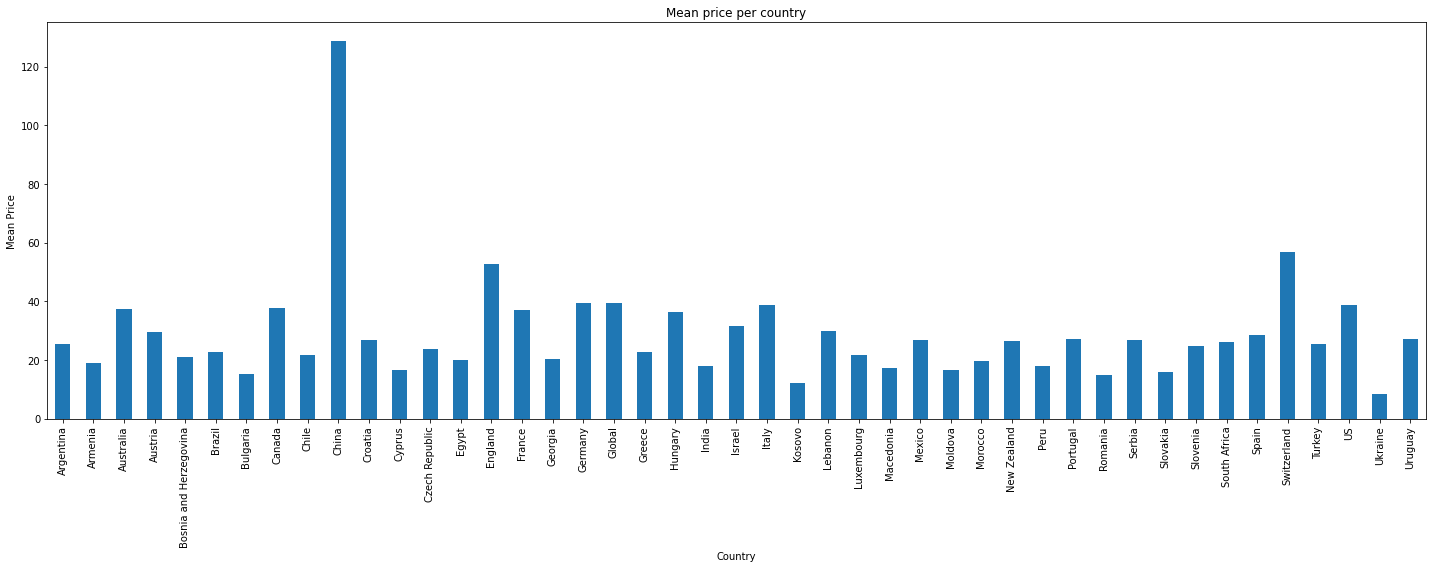

In [637]:
#Create a bar plot for only the mean price by countries: 
fig, ax = plt.subplots(figsize = (20, 8))

reviewdf1.groupby(reviewdf1['country'])['price'].mean().plot.bar()
meanprice = reviewdf1['price'].mean(0)

#create labels: 
ax.set_xlabel('Country')
ax.set_ylabel('Mean Price')

#set the titles:
ax.set_title('Mean price per country')

fig.tight_layout()

In [638]:
'''Question 4: How many wines were reviewed by category? What are the top 10 wine varieties reviewed?  '''
reviewdf1["variety"].describe()

count         211017
unique           853
top       Pinot Noir
freq           22313
Name: variety, dtype: object

In [639]:
#Number of unique wine varieties in the review? 
winetypes = reviewdf1['variety'].unique()
print('There are {} types of wine reviewed in this dataset.'.format(len(winetypes)))

There are 853 types of wine reviewed in this dataset.


In [640]:
#using pd.crosstab function to do the count (a different way than groupby)
winevariety = pd.crosstab(index = reviewdf1['variety'], columns = 'count').sort_values('count' , ascending = False)
winevariety.to_csv("winevarietycount.csv")
print("The top 10 wine types reviewed are:", winevariety[:10])

The top 10 wine types reviewed are: col_0                     count
variety                        
Pinot Noir                22313
Chardonnay                18359
Cabernet Sauvignon        14598
Bordeaux-style Red Blend  12155
Red Blend                  8935
Riesling                   8293
Sauvignon Blanc            7920
Rosé                       6942
Syrah                      6353
Red Blends                 5098


Text(0, 0.5, 'The number of wine variety presented')

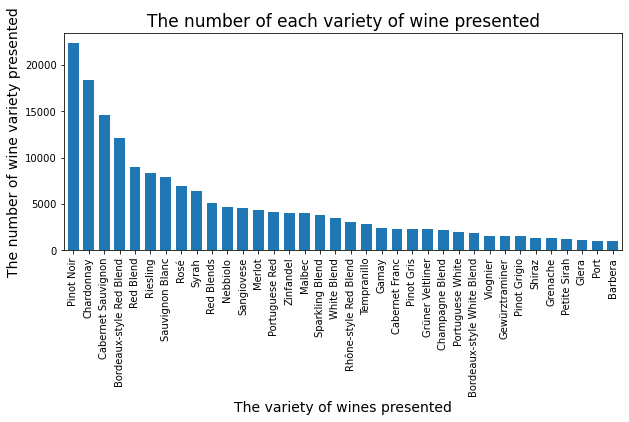

In [641]:
##Plot only the ones that are over 1000 reviews. 
wines_var = winevariety[winevariety['count'] > 1000]
#Set up the parameters for the figure size: 
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
wines_var['count'].plot(kind = 'bar', width = 0.7)
plt.title("The number of each variety of wine presented", fontsize= 17)
plt.xlabel("The variety of wines presented", fontsize = 14)
plt.ylabel("The number of wine variety presented", fontsize = 14)

In [853]:
'''Question 5: What are the max scores, min scores and mean of review scores, particular for top 10 most reviewed varieties?'''
reviewbyvariety = reviewdf1.groupby(['variety']).points.agg([len, np.mean, min, max]).sort_values('len', ascending = False)
print("The most reviewed wines and their min and max review scores:", reviewbyvariety.head(10))

The most reviewed wines and their min and max review scores:                             len       mean  min  max
variety                                             
Pinot Noir                22313  89.812441   80  100
Chardonnay                18359  88.745574   80  100
Cabernet Sauvignon        14598  88.823811   80  100
Bordeaux-style Red Blend  12155  89.516907   80  100
Red Blend                  8935  88.380862   80   99
Riesling                   8293  89.949114   80   98
Sauvignon Blanc            7920  87.734091   80  100
Rosé                       6942  87.146644   80   96
Syrah                      6353  89.763576   80  100
Red Blends                 5098  88.787760   80   99


In [854]:
'''Question 6: What was the average price, min, and max price of wine by variety?''' 
pricebyvariety = reviewdf1.groupby(['variety']).price.agg([len, np.mean, min, max]).sort_values('len', ascending = False)
print(pricebyvariety[:10])

                            len       mean  min     max
variety                                                
Pinot Noir                22313  47.567696  5.0  2500.0
Chardonnay                18359  35.645460  4.0  2013.0
Cabernet Sauvignon        14598  51.446294  4.0   625.0
Bordeaux-style Red Blend  12155  41.693871  7.0  3400.0
Red Blend                  8935  35.056631  5.0   500.0
Riesling                   8293  32.078018  5.0   775.0
Sauvignon Blanc            7920  21.286995  4.0   159.0
Rosé                       6942  19.129069  5.0   800.0
Syrah                      6353  41.406265  4.0   750.0
Red Blends                 5098  36.614751  5.0  2018.0


In [644]:
'''Question 7: For each country, what type of wine is most reviewed?'''
review_mostcommon = reviewdf1.groupby('country').variety.max()
print("The most commonly reviewed wine variety for each country is:\n", review_mostcommon)

The most commonly reviewed wine variety for each country is:
 country
Argentina                         White Blend
Armenia                              Voskehat
Australia                           Zinfandel
Austria                   Zweigelt-Pinot Noir
Bosnia and Herzegovina                Žilavka
Brazil                                 Tannat
Bulgaria                          White Blend
Canada                            White Blend
Chile                             White Blend
China                                    Rosé
Croatia                              Zweigelt
Cyprus                              Xynisteri
Czech Republic                 Welschriesling
Egypt                                Grenache
England                           White Blend
France                            White Blend
Georgia                           White Blend
Germany                           White Blend
Global                            White Blend
Greece                              Xinomavro
Hungary   

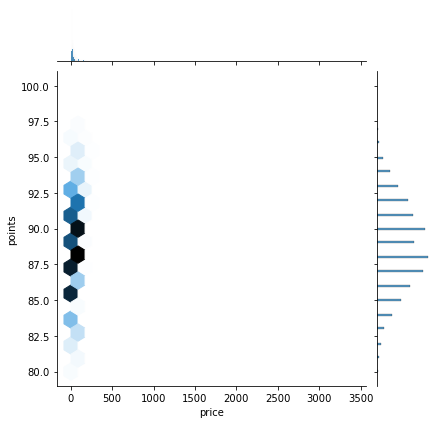

In [856]:
'''Question 8: What is the correlation between the price and score of a bottle of wine?'''

#First we start with some plotting to get the relationship between price and points the wines received. 

#Here I have chosen a hex grid, which allows me to visualize the density of point and pricing and how these two vairables interacted.

#Since we see that over 75% of the wine were priced at under 40, with mean price of appoximately 30 and a std of 34. Therefore, I have decided not to include wine over 100 dollars. 

hexplot1 = sns.jointplot(x='price', y='points', data=reviewdf1, kind='hex', gridsize=20)

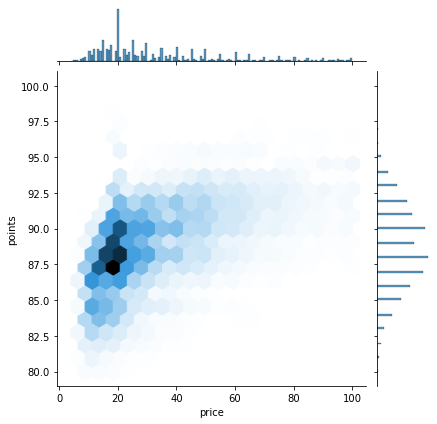

In [857]:
hexplot2 = sns.jointplot(x='price', y='points', data=reviewdf1[reviewdf1['price']<=100], kind='hex', gridsize=20)

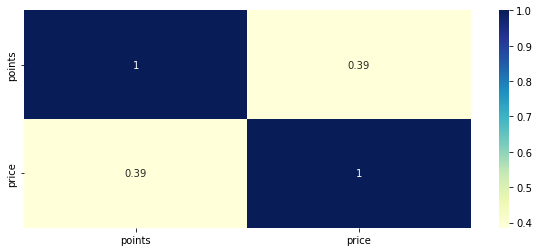

In [647]:
sns.heatmap(reviewdf1.corr(), cmap="YlGnBu", annot = True)
plt.show()

In [648]:
#Run the actual linear regression: 
#I used this resource to help me: https://www.geeksforgeeks.org/python-linear-regression-using-sklearn/


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, svm

df_binary = reviewdf1[['price', 'points']]

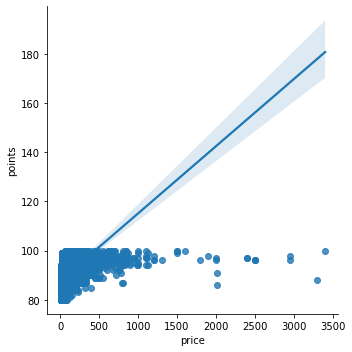

In [649]:
##Linear regression plotting:
#Draw Line of best fit for the price and points 
scatterplot = sns.lmplot(x='price', y='points', data=df_binary)


In [650]:
# Separating the data into independent and dependent variables
# Converting each dataframe into a numpy array 
# since each dataframe contains only one column
x = np.array(df_binary['price']).reshape(-1, 1)
y = np.array(df_binary['points']).reshape(-1, 1)

# Splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [651]:
#train the model with linear regression algorithm

regressor = LinearRegression()
regressor.fit(x_train, y_train)
print(regressor.score(x_test, y_test))

#The accuracy score or R2 is rather low in this case, which means only 17.3% of 60% of the variability observed in points is explained by the price of wine.

0.14581173787357826


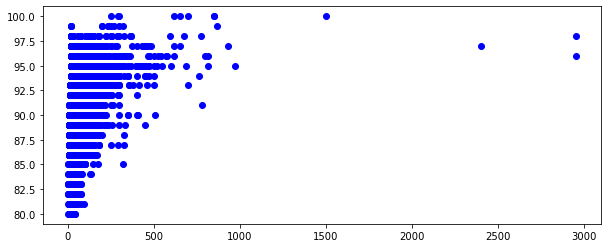

In [652]:
plt.scatter(x_test, y_test, color ='b')
plt.show()
# Data scatter of predicted values

In [653]:
y_pred = regressor.predict(x_test)

In [654]:
#Print out the intercept
print(regressor.intercept_)

[87.823799]


In [657]:
#Print out the slope
print(regressor.coef_)

[[0.02757281]]


In [658]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
#squared True returns MSE value, False returns RMSE value.
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
  
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 2.214681284595773
MSE: 7.834222956783765
RMSE: 2.798968195028976


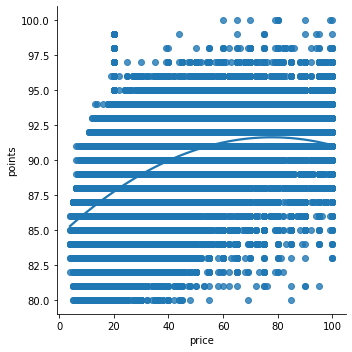

In [659]:
#If I fine tune the price to exclude anything more than 100 dollars. 
df_binary100 = df_binary[df_binary['price'] <=100]
# Selecting only 100 dollar or below wine in the data
sns.lmplot(x ="price", y ="points", data = df_binary100,
                               order = 2, ci = None)

In [660]:
x1 = np.array(df_binary100['price']).reshape(-1, 1)
y1 = np.array(df_binary100['points']).reshape(-1, 1)

# Splitting the data into training and testing data
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.2)
regressor.fit(x_train1, y_train1)
print(regressor.score(x_test1, y_test1))


0.2684521662544609


In [661]:
#Print out all the stats associated with linear regression models: 
y_pred1 = regressor.predict(x_test1)
print(regressor.intercept_)
print(regressor.coef_)

mae1 = mean_absolute_error(y_true=y_test1,y_pred=y_pred1)
#squared True returns MSE value, False returns RMSE value.
mse1 = mean_squared_error(y_true=y_test1,y_pred=y_pred1) #default=True
rmse1 = mean_squared_error(y_true=y_test1,y_pred=y_pred1,squared=False)
  
print("MAE for the second model:",mae1)
print("MSE for the second model:",mse1)
print("RMSE for the second model:",rmse1)

#Not much of improvement. So without being said, there is not a linear relationship between price and points.

[86.23728313]
[[0.07818171]]
MAE for the second model: 2.0079688690270845
MSE for the second model: 6.367260218007015
RMSE for the second model: 2.5233430638751866


In [662]:
'''Question 9: What types of descriptors were frequently associated categories of wine in the reviews? e.g. what kind of fruit flavor were typically used in the wine reviews? 
Since there are 865 types of wine in total. I will only look at the top 3 most reviewed wines: 
Pinot Noir, 
 '''

#Subsetting the data based on their wine variety:
pinot = reviewdf1[reviewdf1['variety'] == 'Pinot Noir']
chardonnay = reviewdf1[reviewdf1['variety'] == 'Chardonnay']
cab = reviewdf1[reviewdf1['variety'] == 'Cabernet Sauvignon']


In [663]:
#A quick view of the dataset that contains only pinot noir wine. 
print(pinot.head())
pinot.describe()

   country                                        description  points  price  \
4       US  Much like the regular bottling from 2012, this...      87   65.0   
21      US  A sleek mix of tart berry, stem and herb, alon...      87   20.0   
25      US  Oak and earth intermingle around robust aromas...      87   69.0   
35      US  As with many of the Erath 2010 vineyard design...      86   50.0   
41      US  A stiff, tannic wine, this slowly opens and br...      86   22.0   

      province     variety                                    tokenized_words  
4       Oregon  Pinot Noir  ['much', 'like', 'regular', 'bottling', 'comes...  
21      Oregon  Pinot Noir  ['sleek', 'mix', 'tart', 'berry', 'stem', 'her...  
25  California  Pinot Noir  ['oak', 'earth', 'intermingle', 'around', 'rob...  
35      Oregon  Pinot Noir  ['many', 'erath', 'vineyard', 'designates', 's...  
41      Oregon  Pinot Noir  ['stiff', 'tannic', 'slowly', 'opens', 'brings...  


,points,price
count,22313.000000,22313.000000
mean,89.812441,47.567696
std,3.029466,41.310803
min,80.000000,5.000000
25%,88.000000,28.000000
50%,90.000000,44.000000
75%,92.000000,58.000000
max,100.000000,2500.000000


In [664]:
print(chardonnay.head())
chardonnay.describe()

   country                                        description  points  price  \
14      US  Building on 150 years and six generations of w...      87   12.0   
55      US  This shows jelly-like flavors of orange and pe...      85   30.0   
56      US  This is weighty, creamy and medium to full in ...      85   14.0   
65  France  From the warm 2015 vintage, this is a soft and...      86   24.0   
66  France  This soft, rounded wine is ripe with generous ...      86   15.0   

      province     variety                                    tokenized_words  
14  California  Chardonnay  ['building', 'years', 'six', 'generations', 'w...  
55  California  Chardonnay  ['shows', 'jelly-like', 'orange', 'pear', 'ear...  
56  California  Chardonnay  ['weighty', 'creamy', 'medium', 'full', 'body'...  
65    Burgundy  Chardonnay  ['warm', 'vintage', 'soft', 'fruity', 'open', ...  
66    Burgundy  Chardonnay  ['soft', 'rounded', 'ripe', 'generous', 'pear'...  


,points,price
count,18359.000000,18359.000000
mean,88.745574,35.645460
std,3.180798,39.091806
min,80.000000,4.000000
25%,87.000000,19.000000
50%,89.000000,28.000000
75%,91.000000,42.000000
max,100.000000,2013.000000


In [665]:
print(cab.head())
cab.describe()

   country                                        description  points  price  \
10      US  Soft, supple plum envelopes an oaky structure ...      87   19.0   
12      US  Slightly reduced, this wine offers a chalky, t...      87   34.0   
37   Italy  This concentrated Cabernet offers aromas of cu...      86   21.0   
60      US  Syrupy and dense, this wine is jammy in plum a...      86  100.0   
71      US  Big oak defines this robustly dense and extrac...      86   40.0   

             province             variety  \
10         California  Cabernet Sauvignon   
12         California  Cabernet Sauvignon   
37  Sicily & Sardinia  Cabernet Sauvignon   
60         California  Cabernet Sauvignon   
71         California  Cabernet Sauvignon   

                                      tokenized_words  
10  ['soft', 'supple', 'plum', 'envelopes', 'oaky'...  
12  ['slightly', 'reduced', 'offers', 'chalky', 't...  
37  ['concentrated', 'cabernet', 'offers', 'aromas...  
60  ['syrupy', 'dense', 

,points,price
count,14598.000000,14598.000000
mean,88.823811,51.446294
std,3.245697,46.229849
min,80.000000,4.000000
25%,87.000000,20.000000
50%,89.000000,38.000000
75%,91.000000,65.000000
max,100.000000,625.000000


In [666]:
#Make a list with all the tokenized words that for three types of wine
#For pinot noir: 
pinot["tokenized_words"] = pinot["tokenized_words"].apply(eval)
pinottokens = []
for sublist in pinot["tokenized_words"]:
    for item in sublist:
        pinottokens.append(item)    

/var/folders/94/jd4kq_w52nlgjf9bgbdl12lw0000gn/T/ipykernel_48033/2225489261.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [667]:
#20 most frequent words associated with pinot noir: 
from nltk import FreqDist
worddistpinot = FreqDist(pinottokens)
worddistpinot.most_common(20)

[('cherry', 9299),
 ('fruit', 9160),
 ('acidity', 5777),
 ('palate', 5712),
 ('tannins', 5629),
 ('red', 5229),
 ('pinot', 4992),
 ('black', 4911),
 ('finish', 4864),
 ('aromas', 4171),
 ('ripe', 3927),
 ('nose', 3875),
 ('oak', 3862),
 ('raspberry', 3857),
 ('light', 3363),
 ('spice', 2932),
 ('noir', 2818),
 ('strawberry', 2633),
 ('rich', 2624),
 ('texture', 2579)]

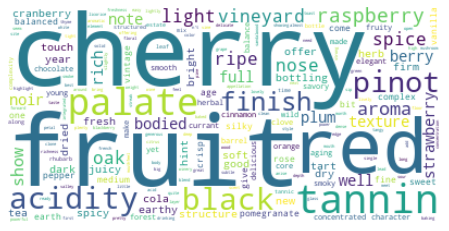

In [668]:
#Generate word clouds for pinot noir only: 
stemmer = nltk.stem.WordNetLemmatizer()    #first stemming the words that have the same root. 
pinottext = " ".join(stemmer.lemmatize(token) for token in pinottokens)   #flatten the nested list of tokens into a long string
wordcloud1 = WordCloud(collocations = False, background_color = "white").generate(pinottext)
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [669]:
#For Chardonnay, 20 most frequent words associated: 
chardonnay["tokenized_words"] = chardonnay["tokenized_words"].apply(eval)
chardtokens = []
for sublist in chardonnay["tokenized_words"]:
    for item in sublist:
        chardtokens.append(item)

/var/folders/94/jd4kq_w52nlgjf9bgbdl12lw0000gn/T/ipykernel_48033/3370328216.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [670]:
worddistchard = FreqDist(chardtokens)
worddistchard.most_common(20)

[('acidity', 6851),
 ('apple', 6270),
 ('fruit', 5570),
 ('palate', 5051),
 ('oak', 4457),
 ('aromas', 4452),
 ('finish', 4366),
 ('ripe', 4323),
 ('chardonnay', 4103),
 ('lemon', 3964),
 ('pear', 3533),
 ('texture', 3172),
 ('nose', 3156),
 ('rich', 3128),
 ('crisp', 3018),
 ('citrus', 2838),
 ('white', 2737),
 ('vanilla', 2625),
 ('peach', 2589),
 ('fresh', 2336)]

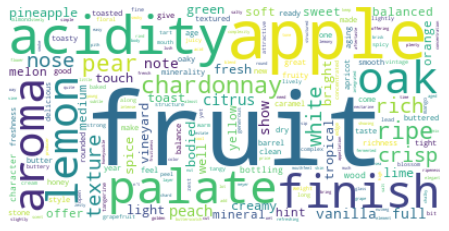

In [671]:
chardtext = " ".join(stemmer.lemmatize(token) for token in chardtokens)   #flatten the nested list of tokens into a long string
wordcloud2 = WordCloud(collocations = False, background_color = "white").generate(chardtext)
plt.imshow(wordcloud2, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [672]:
#For Cabernet Sauvignon:
cab["tokenized_words"] = cab["tokenized_words"].apply(eval)
cabtokens = []
for sublist in cab["tokenized_words"]:
    for item in sublist:
        cabtokens.append(item)
#20 most common words for cabernet:
worddistcab = FreqDist(cabtokens)
worddistcab.most_common(20)

/var/folders/94/jd4kq_w52nlgjf9bgbdl12lw0000gn/T/ipykernel_48033/1439854370.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[('black', 5594),
 ('tannins', 5567),
 ('fruit', 5244),
 ('aromas', 4783),
 ('cherry', 4749),
 ('finish', 4202),
 ('oak', 4198),
 ('palate', 4035),
 ('cabernet', 3888),
 ('blackberry', 3355),
 ('plum', 2451),
 ('red', 2430),
 ('notes', 2353),
 ('cassis', 2256),
 ('ripe', 2254),
 ('currant', 2207),
 ('chocolate', 2183),
 ('dark', 2168),
 ('berry', 2001),
 ('spice', 1963)]

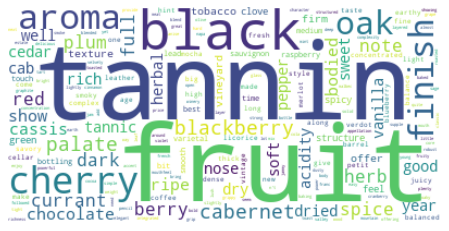

In [673]:
cabtext = " ".join(stemmer.lemmatize(token) for token in cabtokens)   #flatten the nested list of tokens into a long string
wordcloud3 = WordCloud(collocations = False, background_color = "white").generate(cabtext)
plt.imshow(wordcloud3, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [586]:
'''Question 9: What kind of account tweeted most about wine and what time during 10 day period before Thanksgiving 2022?
This part is from my HW2 and sorry that I did not work too much on it)'''

#Load the packages necessary for MongoDB
import pymongo
from pymongo import MongoClient

In [587]:
client = MongoClient('localhost', 27017)

# show existing databases
client.list_database_names()

['Dunkin',
 'admin',
 'bball2022',
 'bikes',
 'config',
 'local',
 'peopledb',
 'usgs',
 'usgsDB',
 'winetweets']

In [588]:
#Call out the wine twitter data from MangoDB
winedb = client.winetweets
winedb.list_collection_names()

#update the database
coll=winedb.winetweets1  
type(coll)

docs = coll.find()
#convert document cursor to a list of documents

doclist = [tweet for tweet in docs]
len(doclist)
#There are 9813 records of tweets in the database from 11/14 to 11/24 (10 days period until the day of ThanksGiving)

9813

In [589]:
print(doclist[:1]) #print out the first record and see the data structure. 

[{'_id': ObjectId('6399c721c8f8e22ca54947f9'), 'Datetime': 1669334354000, 'Text': 'We had a nice bottle of #wine tonight. I wanted to a nicer bottle but my wife said that our philistine guests wouldn’t appreciate it \n\nOne of our guests said drinking this wine was like “going to a Pantera concert”. \n\nI had notes of strawberry and blueberry, but whatever. https://t.co/mZGTTa5ghe', 'User': 'markreinoso', 'Location': 'Senoia, GA', 'Description': 'Native of Ecuador, USA citizen. I own multiple businesses. Food, wine, economics, points. Working in PHX, living on acreage in GA and summer-ing in PDX', 'Followers': 101, 'Friends': 97, 'TotalTweet': 2595, 'Retweet': 0, 'Likes': 3, 'Quotes': 0, 'Mentioned': None}]


In [590]:
#Create a new empty list to read from the doclist that contains all the tweets from the database
tweets_list1=[]
for tweet in doclist:
    tweets_list1.append([tweet['Datetime'], tweet['User'], tweet['Location'], tweet['Followers'], tweet['TotalTweet'], tweet['Likes']]) 
    #declare the attributes to be returned 
# Creating a dataframe from the tweets list above 
tweetsdf1 = pd.DataFrame(tweets_list1, columns=['Datetime', 'User', 'Location', 'Followers', 'TotalTweets', 'Likes'])

In [591]:
#Brief inspection shows that the datetime variable has been saved as unix timestamps in JSON and I need to preprocess it. 
tweetsdf1.head()

,Datetime,User,Location,Followers,TotalTweets,Likes
0,1669334354000,markreinoso,"Senoia, GA",101,2595,3
1,1669334280000,jacy1273,,65,317,0
2,1669334273000,Dedric84P,,12,4553,0
3,1669333828000,InfoAuMax1,,80,10736,0
4,1669333657000,bonesondisplay,"Pennsylvania, USA",1830,17118,0


In [592]:
#Clean up the datetime variable 

from datetime import datetime
#First, convert the unix timestamp from the json file reading to human readable time
#This post on stackoverflow helped: https://stackoverflow.com/questions/41783003/how-do-i-convert-timestamp-to-datetime-date-in-pandas-dataframe
tweetsdf1['Datetime']=(pd.to_datetime(tweetsdf1['Datetime'],unit='ms')) 

#Divide the column of datetime into date, weekday, and hours. The code I used is: https://datagy.io/pandas-extract-date-from-datetime/
tweetsdf1['Date'] = tweetsdf1['Datetime'].dt.date
tweetsdf1['Weekday']=tweetsdf1['Datetime'].dt.weekday   #New column weekday showing which day of the week the date is [0 = Monday; 6 = Sunday]
tweetsdf1['Hours']=tweetsdf1['Datetime'].dt.hour   #New column hour showing which hour is the tweet posted (0 -23 h of a day)

In [593]:
#Question 4: Who are the top three users who posted most frequent during the period?
tweetusers = tweetsdf1['User'].value_counts()    #count the value of each unique username to find out the tweets they made respectively
tweetusers[:10]

#The top ten users are as follows and most of them are either official account or wine related public account (bloggers etc.)

JournalVin         174
DailyKeg           129
WineSelfies        109
masi3v             108
mivino_app         102
esquireattire      101
WaterfordWine       97
WineIndustryJob     94
VinoTQM             93
CharlesRoseWine     89
Name: User, dtype: int64

In [594]:
#How many users tweeted during the week prior to Thanksgiving based on the Date? 
startdate = pd.to_datetime("2022-11-18").date()  #change the format of 2022-11-14 from str to datetime
enddate = pd.to_datetime("2022-11-24").date()    #same operation
tweetsdf2 = tweetsdf1.loc[tweetsdf1["Date"].between(startdate, enddate)]  #Now the new dataframe can be subesetted.

            User
Date            
2022-11-18   976
2022-11-19   833
2022-11-20   792
2022-11-21   927
2022-11-22   894
2022-11-23  1032
2022-11-24   956
AxesSubplot(0.125,0.125;0.775x0.755)


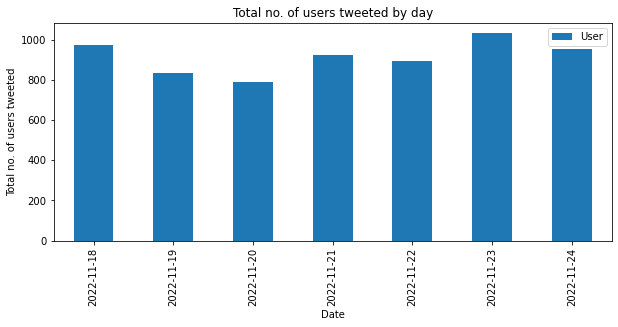

In [595]:
#In other words, what day tweeters users are more likely to tweet during the period of Nov. 18 - 24?  
res1 = tweetsdf2.pivot_table(index='Date', values = ['User'], aggfunc=len)
print(res1)
dplot1 = res1.plot.bar(stacked=False)     #Plot the bar plot using res1 output. 
labels = res1.index                      #Use the index values of res1
dplot1.set_ylabel('Total no. of users tweeted')
dplot1.set_title('Total no. of users tweeted by day')
dplot1.set_xticklabels(labels)

print(dplot1)
#On Wednesday, 11-23-22, tweeter users are most actively using the hastags of #wine and #winetasting

        User                        
Weekday    0   1   2   3   4   5   6
Hours                               
0         37  38  46  36  38  46  40
1         39  27  28  34  27  30  22
2         30  31  40  42  33  35  26
3         23  23  30  27  32  29  23
4         25  24  26  21  24  31  17
5         18  16  24  30  15  16  13
6         18  27  35  25  30  26  25
7         20  18  16  20  13  15  21
8         35  25  24  27  20  25  31
9         46  40  34  64  49  27  31
10        48  23  29  36  40  26  36
11        37  30  41  34  45  23  30
12        45  43  51  43  46  32  41
13        55  37  49  48  34  42  45
14        47  41  57  40  43  43  35
15        62  56  65  56  61  39  44
16        56  76  58  56  67  48  38
17        49  59  69  58  64  61  37
18        56  49  54  67  62  60  40
19        26  52  50  44  45  43  43
20        52  51  51  52  64  36  36
21        35  35  51  43  49  36  53
22        41  36  57  25  41  29  36
23        27  37  47  28  34  35  29


Text(0.5, 1.0, 'Total no. of users tweeted by weekday and hours')

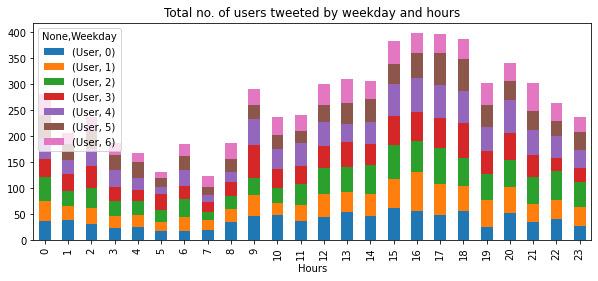

In [596]:
#Question : How many users tweeted for each hour of each day during the week? 
res2 = tweetsdf2.pivot_table(index='Hours', columns = 'Weekday', values = ['User'], aggfunc=len)
print(res2)
dplot2 = res2.plot.bar(stacked=True, )     #Plot the bar plot using res1 output.                    #Use the index values of res1
dplot2.set_title('Total no. of users tweeted by weekday and hours')